# Simulation

#### Michael Pyrcz, Professor, The University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

This is a tutorial for / demonstration of **Spatial Simulation with Sequential Gaussian Simulation (SGSIM)** with a 2D map example.

* sequential Gaussian simulation is a common geostatistical method for calculating spatial models with an appropriate level of heterogeneity


**YouTube Lecture**: check out my lecture on [Stochastic Simulation](https://youtu.be/3cLqK3lR56Y?si=3WhHX5QOZrrtlgAI). For your convenience here's a summary of salient points.

#### Estimation vs. Simulation

Let's start by comparing spatial estimation and simulation.

Estimation: 

* honors local data 
* locally accurate, primary goal of estimation is 1 estimate! 
* too smooth, appropriate for visualizing trends 
* too smooth, inappropriate for flow simulation 
* one model, no assessment of global uncertainty 

Simulation: 

* honors local data 
* sacrifices local accuracy, reproduces histogram 
* honors spatial variability, appropriate for flow simulation 
* alternative realizations, change random number seed 
* many models (realizations), assessment of global uncertainty

No let's explain the concept of spatial simulation.

#### Spatial Simulation

This method is critical for:

1. Prediction away from wells, e.g. pre-drill assessments, with uncertainty 
2. Spatial uncertainty modeling.
3. Heterogeneity realizations ready for application to the transfer function.

#### Sequential Gaussian Simulation

With sequential Gaussian simulation we build on kriging by:

* adding a random residual with the missing variance

* sequentially adding the simulated values as data to correct the covariance between the simulated values

The resulting model corrects the issues of kriging, as we now:

* reproduce the global feature PDF / CDF

* reproduce the global variogram

* while providing a model of uncertainty through multiple realizations

In this workflow we run multiple simulation realizations, and check the statistics.

#### Load the required libraries

The following code loads the required libraries. 

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))

GeostatsPy version: 0.0.71


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # supress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrys for gridded data
import pandas as pd                                           # DataFrames for tabular data
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib import gridspec                               # custom subplots
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
from IPython.utils import io                                  # mute output from simulation
cmap = plt.cm.inferno                                         # color map

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

Here's a convenience function for plotting variograms.

In [3]:
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks   

def vargplot(feature,lags,gamma_maj,gamma_min,npps_maj,npps_min,vmodel,azi,atol,sill): # plot the variogram
    index_maj,lags_maj,gmod_maj,cov_maj,ro_maj = geostats.vmodel(nlag=100,xlag=10,azm=azi,vario=vmodel);
    index_min,lags_min,gmod_min,cov_min,ro_min = geostats.vmodel(nlag=100,xlag=10,azm=azi+90.0,vario=vmodel);
    
    plt.scatter(lags,gamma_maj,color = 'black',s = npps_maj*0.01,label = 'Major Azimuth ' +str(azi), alpha = 0.8)
    plt.plot(lags_maj,gmod_maj,color = 'black')
    plt.scatter(lags,gamma_min,color = 'red',s = npps_min*0.01,label = 'Minor Azimuth ' +str(azi+90.0), alpha = 0.8)
    plt.plot(lags_min,gmod_min,color = 'red',label = 'Input Major Model')
    plt.plot([0,2000],[sill,sill],color = 'black',label = 'Input Minor Model')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    if atol < 90.0:
        plt.title('Check Directional ' + feature + ' Variogram')
    else: 
        plt.title('Check Omnidirectional NSCORE ' + feature + ' Variogram')
    plt.xlim([0,1000]); #plt.ylim([0,1.8])
    plt.legend(loc="lower right")
    add_grid()

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [4]:
#os.chdir("c:/PGE383")                                     # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. 

* We will also extract a limited sample to reduce data density. This way we can observe more of the heterogeneity from the simulation with the spatial continuity model, rather than mostly data driven heterogeneity.

* By setting unconditional to True the data are shifted well outside the area of interest and are only used for the target reference distribution

In [5]:
unconditional = False
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_MV_biased.csv") # from Dr. Pyrcz's GitHub repo
df = df.sample(50)                                        # extract 50 samples
df = df.reset_index()                                     # reset the record index 
df = df.drop(['index','Unnamed: 0','AI'],axis=1)          # remove extra columns in DataFrame
df['logPerm'] = np.log(df['Perm'].values)                 # calculate the log of permeability
if unconditional == True:
    df['X'] = df['X'] + 9999999.9                         # move the data outside the model, just use the distributions as a reference to constrain the simulated distributions
df.head()                                                 # DataFrame summary

,X,Y,Facies,Porosity,Perm,logPerm
0,300.0,200.0,0.0,0.073276,0.523248,-0.647699
1,330.0,319.0,0.0,0.100149,4.667175,1.540554
2,940.0,799.0,0.0,0.091960,0.192133,-1.649566
3,890.0,919.0,0.0,0.109401,1.335762,0.289502
4,600.0,700.0,1.0,0.116428,4.525924,1.509822


#### Sequential Gaussian Simulation

Let's jump right to building a variety of models with simulation and visualizing the results.  We will start with a test of 3 realizations.

* look at the realizations and check the histogram and variograms

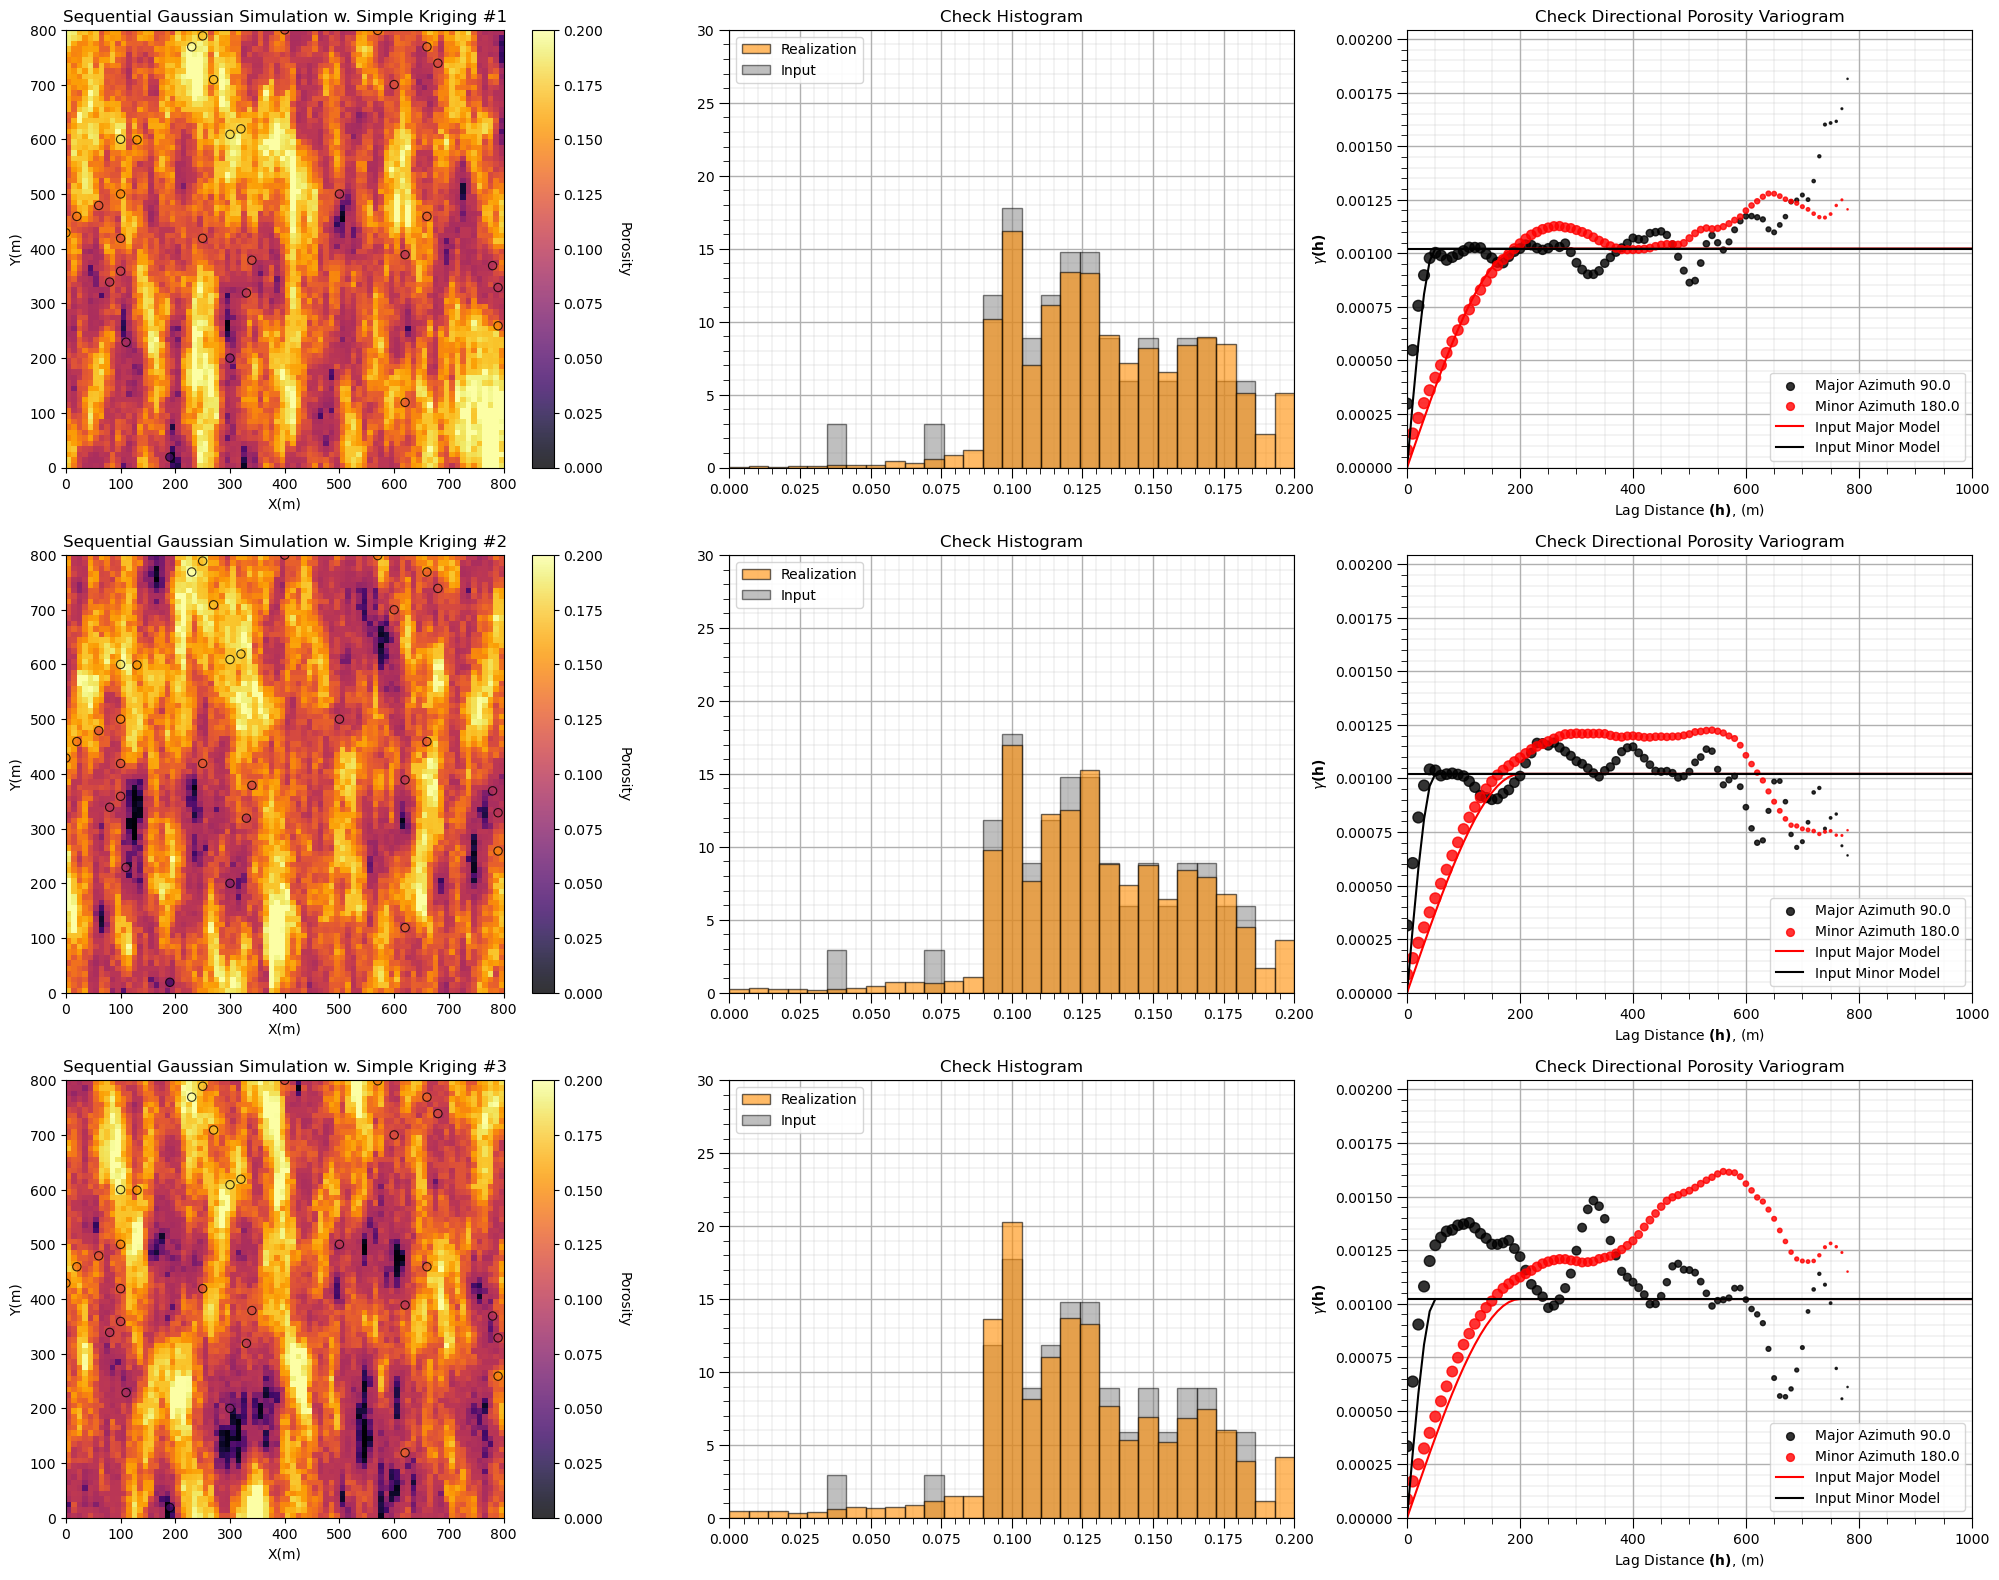

In [6]:
%%capture --no-display                                                                

zmin = 0.00; zmax = 0.20                                  # feature min and max values 
nx = 80; ny = 80; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1 # grid specification
nreal = 3                                                 # number of realizations
ndmin = 0; ndmax = 20                                     # number of data for each kriging system
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0.0,hmaj1=200,hmin1=50)
tmin = -999; tmax = 999
sill = np.std(df['Porosity'].values)*np.std(df['Porosity'].values)

sim_sk = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=zmin,zmax=zmax,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=nreal,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=1,nmult=3,noct=-1,ktype=0,colocorr=0.0,sec_map=0,vario=vario);

xmin = xmn-xsiz/2; xmax = nx*xsiz + xmin; ymin = ymn-ysiz/2; ymax = ny*ysiz + ymin; cmap = plt.cm.inferno # plotting parameters

for isim in range(0,nreal):
    plt.subplot(nreal,3,1 + isim*3)                                          # plot the results
    GSLIB.locpix_st(sim_sk[isim],xmin,xmax,ymin,ymax,xsiz,zmin,zmax,df,'X','Y','Porosity','Sequential Gaussian Simulation w. Simple Kriging #' + str(isim+1),'X(m)','Y(m)','Porosity',cmap)
    
    lags, gamma_x, npps_x = geostats.gam(sim_sk[isim],-9999.9,9999.9,xsiz,ysiz,ixd=1,iyd=0,nlag=100,isill=0)
    lags, gamma_y, npps_y = geostats.gam(sim_sk[isim],-9999.9,9999.9,xsiz,ysiz,ixd=0,iyd=1,nlag=100,isill=0)

    plt.subplot(nreal,3,2 + isim*3)
    plt.hist(sim_sk[isim].flatten(),bins=np.linspace(zmin,zmax,30),density=True,color='darkorange',alpha=0.6,edgecolor='black',zorder=10,label='Realization')
    plt.hist(df['Porosity'].values,bins=np.linspace(zmin,zmax,30),density=True,color='grey',alpha=0.5,edgecolor='black',zorder=1,label='Input')
    plt.legend(loc='upper left'); add_grid()
    plt.xlim([zmin,zmax]); plt.ylim([0,30]); plt.title('Check Histogram'); add_grid()
    
    plt.subplot(nreal,3,3 + isim*3)
    vario_plot = vario
    vario_plot.update({"cc1":sill})
    vargplot('Porosity',lags,gamma_x,gamma_y,npps_x,npps_y,vario_plot,azi=90.0,atol=22.5,sill=sill)     # plot the variogram
    plt.xlim([0,1000]); plt.ylim([0.0,sill*2.0])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.1, wspace=0.2, hspace=0.2); plt.show()

#### Comments

This was a basic demonstration of sequential Gaussian simulation to calculate spatial heterogeneity realizations that honor the data, histogram and variogram. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  